Test VAE model

In [1]:
# prepare data
from data_utils import get_data
dataset_used = 'MNIST' #'CIFAR10' #'FashionMNIST' #'MNIST', 'MPII', 'UTD'
train_data_loader, val_data_loader, __ = get_data(dataset_used, 1)


Train size:  54000


In [2]:
# load model
from vae import VAE
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
import torch 

model = VAE(latent_dim=64).eval()
model_name = 'vae_mark'+str(model.mark)+'_'+dataset_used
model.load_state_dict(torch.load('models/'+model_name+'.pth'))
model.eval();

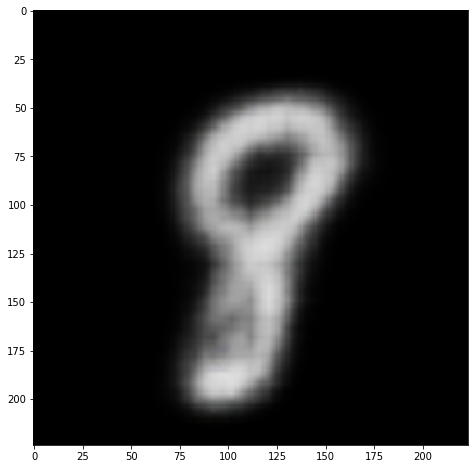

In [3]:
# random sample from latent space
sample = model.sample()[0].permute(1, 2, 0)
plt.imshow(sample.cpu().detach().numpy())
plt.show()

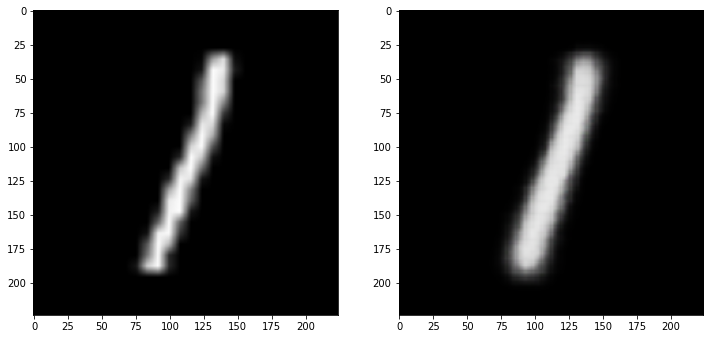

In [10]:
# generate from input
fig, axs = plt.subplots(1, 2)
for batch in val_data_loader:
    if dataset_used in ['MNIST', 'UTD', 'FashionMNIST', 'CIFAR10']:
        img = batch[0]
    elif dataset_used == 'MPII':
        img = batch['image']
        
    img_show = img.squeeze(0).permute(1, 2, 0)
    axs[0].imshow(img_show.detach().numpy())
    gen = model(img)[0].squeeze(0).permute(1, 2, 0)
    axs[1].imshow(gen.cpu().detach().numpy())
    
    plt.show()
    break

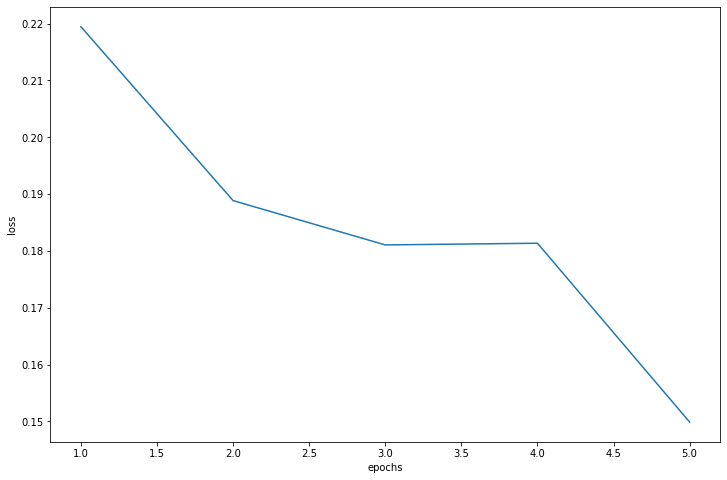

In [5]:
# plot training curve
import json

with open('logs/'+model_name+'.json', 'r') as f:
    losses = json.load(f)

x = range(1, len(losses)+1)
fig, ax = plt.subplots(1, 1)
ax.plot(x, losses)
ax.set_ylabel('loss')
ax.set_xlabel('epochs')
plt.show()